<a href="https://colab.research.google.com/github/KevinM11101005/YOLOv12/blob/main/train_yolov12_object_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = "XarTw09VRJncVEPwvwBe"

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Sat May 31 19:51:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [4]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 72.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [5]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg


--2025-05-31 19:54:14--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-05-31 19:54:14 (81.0 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


100%|██████████| 51.4M/51.4M [00:00<00:00, 113MB/s]


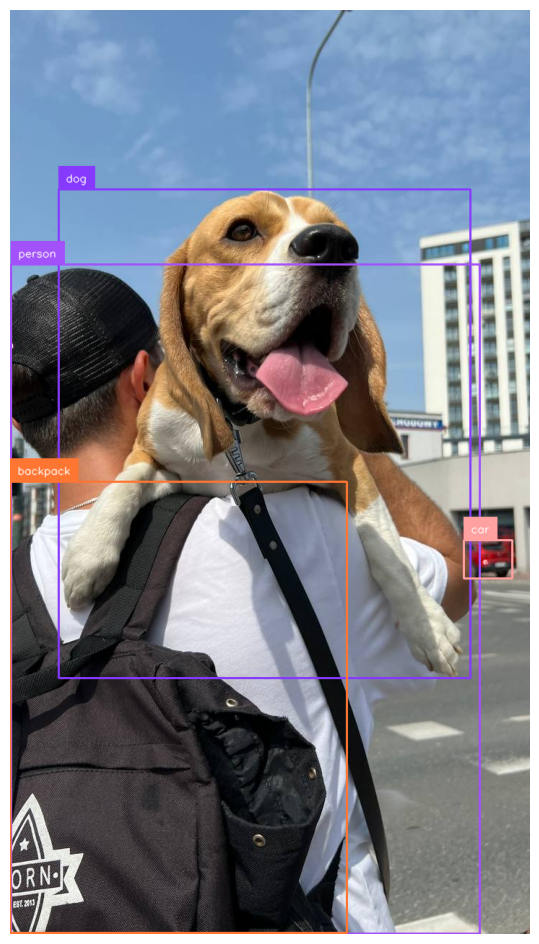

In [6]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [7]:
from roboflow import download_dataset
dataset = download_dataset('https://universe.roboflow.com/roboflow-100/road-signs-6ih4y/dataset/2', 'yolov8')

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to road-signs-2 in yolov8:: 100%|██████████| 4198/4198 [00:00<00:00, 7043.34it/s]


In [8]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [9]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [10]:
!cat {dataset.location}/data.yaml

names:
- bus_stop
- do_not_enter
- do_not_stop
- do_not_turn_l
- do_not_turn_r
- do_not_u_turn
- enter_left_lane
- green_light
- left_right_lane
- no_parking
- parking
- ped_crossing
- ped_zebra_cross
- railway_crossing
- red_light
- stop
- t_intersection_l
- traffic_light
- u_turn
- warning
- yellow_light
nc: 21
roboflow:
  license: CC BY 4.0
  project: road-signs-6ih4y
  url: https://universe.roboflow.com/roboflow-100/road-signs-6ih4y/dataset/2
  version: 2
test: ../test/images
train: ../train/images
val: ../valid/images


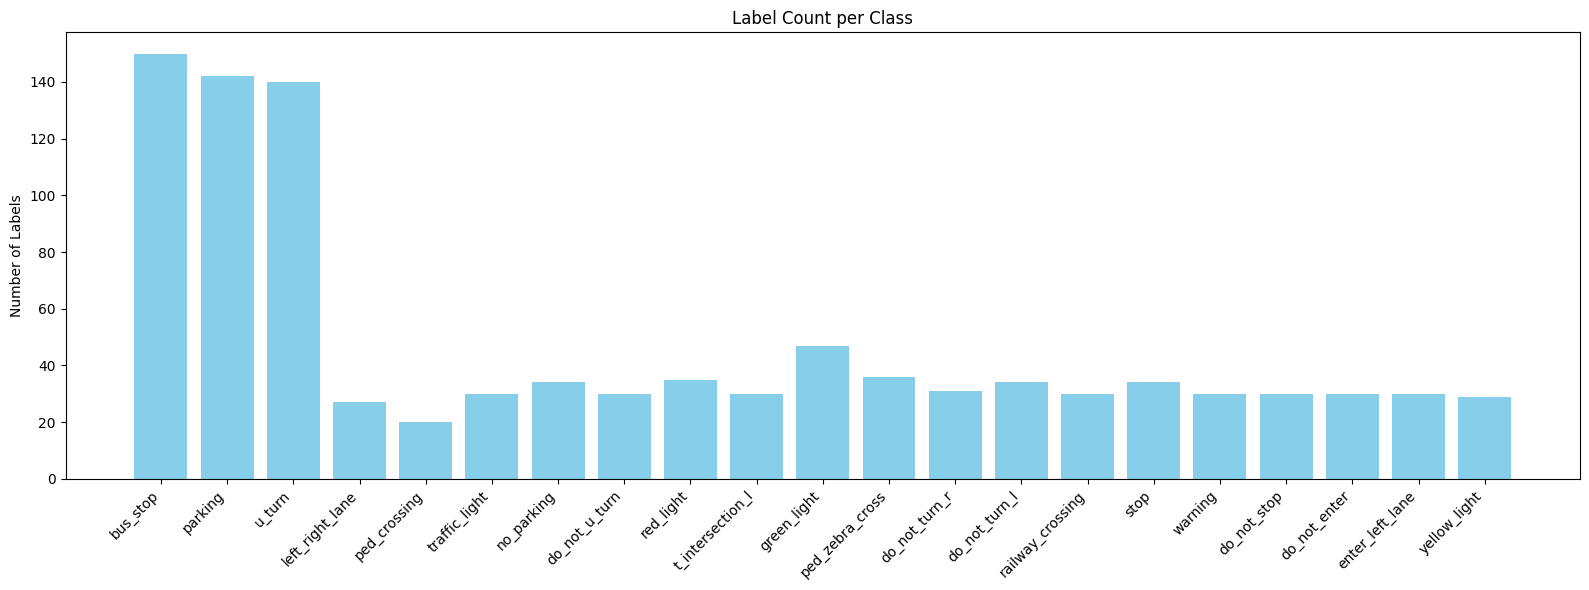

In [11]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# class names
names = [
    'bus_stop', 'do_not_enter', 'do_not_stop', 'do_not_turn_l', 'do_not_turn_r',
    'do_not_u_turn', 'enter_left_lane', 'green_light', 'left_right_lane', 'no_parking',
    'parking', 'ped_crossing', 'ped_zebra_cross', 'railway_crossing', 'red_light',
    'stop', 't_intersection_l', 'traffic_light', 'u_turn', 'warning', 'yellow_light'
]

# 路徑設定
split_dirs = ['/content/road-signs-2/test/labels', '/content/road-signs-2/valid/labels', '/content/road-signs-2/test/labels']
label_counts = defaultdict(int)

# 逐個資料夾讀取標註檔
for dir_path in split_dirs:
    if not os.path.exists(dir_path):
        continue
    for file_name in os.listdir(dir_path):
        if not file_name.endswith('.txt'):
            continue
        with open(os.path.join(dir_path, file_name), 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_id = int(line.split()[0])
                label_counts[class_id] += 1

# 將 class_id 映射為名字
category_counts = {names[class_id]: count for class_id, count in label_counts.items()}

# 確保所有類別都顯示（即使為 0）
for name in names:
    category_counts.setdefault(name, 0)

# 畫直方圖
plt.figure(figsize=(16, 6))
plt.bar(category_counts.keys(), category_counts.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Labels")
plt.title("Label Count per Class")
plt.tight_layout()
plt.show()

## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [12]:
from ultralytics import YOLO

model = YOLO('yolov12s.pt')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=200)

100%|██████████| 17.8M/17.8M [00:00<00:00, 122MB/s] 


New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.pt, data=/content/road-signs-2/data.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save

100%|██████████| 755k/755k [00:00<00:00, 18.5MB/s]


Overriding model.yaml nc=80 with nc=21

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytic

100%|██████████| 5.26M/5.26M [00:00<00:00, 84.6MB/s]


AMP: checks passed ✅


train: Scanning /content/road-signs-2/train/labels... 1376 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1376/1376 [00:00<00:00, 2515.06it/s]

train: New cache created: /content/road-signs-2/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/road-signs-2/valid/labels... 488 images, 0 backgrounds, 0 corrupt: 100%|██████████| 488/488 [00:00<00:00, 1190.26it/s]

val: New cache created: /content/road-signs-2/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.0004, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      6.75G      1.074      3.798      1.354         38        640: 100%|██████████| 86/86 [00:49<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.05it/s]

                   all        488        529       0.49      0.614      0.552      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      6.86G      1.015      1.883      1.276         33        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all        488        529      0.583      0.637      0.612      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      6.86G     0.9751      1.523      1.244         41        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all        488        529      0.581      0.654      0.659      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      6.86G     0.9752       1.38      1.256         29        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all        488        529      0.693      0.701      0.769      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      6.86G     0.9481      1.294      1.238         26        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]


                   all        488        529      0.831      0.739      0.791      0.626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      6.86G     0.9518      1.191      1.247         25        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all        488        529      0.751      0.798      0.836      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      6.86G      0.917      1.116      1.206         33        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]

                   all        488        529      0.819      0.778      0.855      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      6.86G     0.9356      1.052      1.199         31        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]

                   all        488        529      0.781      0.791      0.852      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      6.86G     0.9102      1.011      1.198         35        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]

                   all        488        529      0.895       0.87      0.936      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      6.68G     0.8843     0.9527       1.18         34        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]

                   all        488        529      0.865       0.86      0.907       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      6.69G     0.8931     0.9456      1.189         36        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all        488        529      0.864       0.88      0.923      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200       6.7G     0.8644     0.8852      1.169         29        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all        488        529      0.886      0.851      0.913       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200       6.7G     0.8393     0.8429      1.145         40        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]

                   all        488        529      0.851      0.874      0.923       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      6.69G     0.8368     0.8403      1.145         31        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all        488        529      0.888       0.88      0.931      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      6.69G     0.8206     0.8261      1.153         24        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]

                   all        488        529      0.836      0.877      0.931      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200       6.7G      0.827     0.8259      1.158         30        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all        488        529      0.902      0.818      0.907      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      6.69G     0.8188     0.7783      1.135         29        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all        488        529      0.842        0.9      0.938      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      6.69G     0.8027     0.7438      1.134         35        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

                   all        488        529      0.894      0.869      0.934      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200       6.7G     0.7954     0.7048      1.127         27        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]

                   all        488        529      0.887      0.907      0.935       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200       6.7G     0.8009     0.7393      1.124         32        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]


                   all        488        529      0.882      0.882      0.918      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      6.69G     0.7734     0.7221      1.112         27        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all        488        529      0.868      0.907      0.936      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200       6.7G     0.7707     0.7106      1.115         35        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all        488        529       0.93      0.871      0.924      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      6.69G     0.7891     0.7064      1.122         37        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

                   all        488        529      0.877      0.879      0.915      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200       6.7G     0.7706     0.6859      1.112         29        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]

                   all        488        529      0.912      0.921      0.961      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200       6.7G     0.7513     0.6932      1.104         41        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all        488        529      0.896      0.906       0.94      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200       6.7G     0.7714     0.6685      1.104         33        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all        488        529      0.917       0.91      0.939      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      6.69G     0.7731     0.6655      1.106         40        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all        488        529      0.892      0.935      0.951      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200       6.7G     0.7584     0.6754      1.107         36        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]

                   all        488        529      0.899      0.931      0.956      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200       6.7G     0.7677     0.6772      1.102         36        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all        488        529      0.913      0.927      0.948      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200       6.7G     0.7461     0.6745      1.098         34        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all        488        529      0.923      0.912      0.951      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200       6.7G     0.7191     0.6094      1.076         31        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all        488        529      0.922      0.923      0.948      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200       6.7G     0.7479     0.6234      1.092         22        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all        488        529      0.914      0.924      0.959      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200       6.7G     0.7515     0.6189      1.104         29        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all        488        529      0.911      0.895      0.949      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      6.69G     0.7451     0.6329      1.103         34        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all        488        529      0.932      0.898      0.937      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200       6.7G     0.7219     0.6217      1.071         29        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all        488        529      0.899       0.91      0.941       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      6.68G     0.7399     0.5954      1.094         28        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all        488        529      0.922      0.907      0.953      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      6.69G     0.7498     0.6283      1.087         36        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]

                   all        488        529      0.938      0.893       0.95      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200       6.7G     0.7332      0.599      1.086         26        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all        488        529      0.923      0.909      0.948      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200       6.7G     0.7431     0.6166      1.095         25        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all        488        529      0.933      0.923      0.957      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200       6.7G     0.7303     0.5822      1.079         28        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]

                   all        488        529      0.913      0.923      0.957      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      6.69G       0.72     0.6127      1.069         39        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529      0.919      0.925      0.951      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200       6.7G     0.7004     0.6046      1.061         34        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529       0.91      0.926      0.953      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      6.69G     0.7099     0.5864      1.072         33        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]

                   all        488        529      0.929      0.924      0.958      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200       6.7G     0.7015     0.5693      1.057         28        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all        488        529      0.922      0.929      0.953      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      6.69G     0.6933     0.5605      1.053         36        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]

                   all        488        529       0.92       0.92      0.949      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200       6.7G     0.6872     0.5598      1.059         23        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529      0.929      0.916       0.94       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      6.68G     0.7008     0.5656      1.059         30        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529      0.948      0.932      0.963      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      6.69G     0.6982     0.5636      1.067         38        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all        488        529      0.934      0.926       0.96      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      6.69G     0.6776     0.5533       1.05         32        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]

                   all        488        529      0.929      0.914      0.933      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200       6.7G     0.6759     0.5569      1.044         28        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all        488        529       0.93      0.947      0.955      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200       6.7G     0.6948     0.5474      1.058         34        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

                   all        488        529      0.931      0.937       0.96      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200       6.7G      0.679     0.5335       1.06         27        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529      0.928      0.948      0.959      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      6.69G     0.6585     0.5248      1.042         36        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529      0.929      0.935      0.962        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200       6.7G     0.6877     0.5318      1.052         28        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]

                   all        488        529      0.936      0.935      0.957      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200       6.7G     0.6774     0.5368       1.05         38        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]

                   all        488        529      0.926       0.92      0.943      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200       6.7G     0.6726     0.5454      1.047         31        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all        488        529      0.948      0.938      0.964      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200       6.7G     0.6674      0.516      1.044         42        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.56it/s]

                   all        488        529      0.948      0.935       0.96      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      6.69G     0.6767     0.5078      1.044         31        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529      0.933      0.927      0.951      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200       6.7G     0.6715     0.5234      1.057         32        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529      0.934      0.923      0.952      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200       6.7G     0.6673     0.5291      1.055         39        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]


                   all        488        529      0.934      0.951      0.965       0.81

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200       6.7G     0.6563     0.5089      1.037         26        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all        488        529      0.949      0.945      0.969      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200       6.7G     0.6497     0.5036      1.045         27        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all        488        529      0.927      0.923      0.948      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200       6.7G     0.6582     0.5001      1.034         31        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all        488        529       0.95      0.937      0.971      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200       6.7G     0.6581     0.5153      1.039         30        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529      0.944      0.932      0.955      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200       6.7G     0.6544     0.5033      1.034         20        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

                   all        488        529      0.924      0.937      0.958      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200       6.7G     0.6442     0.4776      1.033         35        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


                   all        488        529      0.946      0.933       0.96      0.803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      6.69G      0.634     0.4867      1.036         32        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all        488        529      0.954      0.928      0.969      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      6.69G     0.6469     0.4934      1.025         37        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]

                   all        488        529      0.939      0.939      0.968      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200       6.7G     0.6601     0.4885      1.034         26        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529      0.944      0.939      0.969      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      6.69G     0.6415     0.4793      1.024         23        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all        488        529      0.939      0.924      0.954      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200       6.7G     0.6122     0.4665      1.012         26        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]


                   all        488        529      0.939      0.949      0.967      0.816

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200       6.7G     0.6451     0.4701      1.037         33        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all        488        529       0.94      0.934      0.964      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      6.69G     0.6382     0.4761      1.026         40        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all        488        529      0.913      0.921      0.934      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      6.69G     0.6263     0.4754       1.02         25        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.56it/s]

                   all        488        529      0.937      0.934      0.963      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200       6.7G     0.6185     0.4661      1.016         31        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all        488        529      0.945      0.949      0.964      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      6.69G      0.625     0.4652      1.021         32        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

                   all        488        529      0.941      0.944      0.962      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200       6.7G     0.6218     0.4741      1.027         25        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all        488        529      0.946      0.941      0.965      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      6.69G     0.6038     0.4476      1.013         33        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]

                   all        488        529      0.942      0.927      0.957      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200       6.7G     0.6227     0.4638       1.03         36        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all        488        529      0.941      0.935      0.964      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      6.68G     0.6053     0.4416      1.016         32        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all        488        529      0.941      0.945      0.971      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200       6.7G     0.5998       0.44      1.015         32        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

                   all        488        529       0.95      0.918      0.965      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200       6.7G     0.5981     0.4428      1.012         28        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.72it/s]

                   all        488        529      0.932      0.918      0.959      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      6.69G     0.6038     0.4557      1.014         32        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all        488        529      0.935      0.936      0.966      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200       6.7G     0.6013     0.4529       1.01         39        640: 100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]

                   all        488        529      0.949      0.916      0.957      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      6.69G     0.6068      0.427       1.02         38        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all        488        529       0.96      0.938      0.967      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200       6.7G     0.5888     0.4306      1.007         29        640: 100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

                   all        488        529      0.939      0.942      0.966       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      6.69G     0.6039      0.451      1.014         41        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all        488        529      0.918       0.94      0.962      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      6.69G     0.5846     0.4245      1.004         35        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

                   all        488        529      0.926      0.945      0.965      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200       6.7G     0.5816     0.4285       1.01         30        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529      0.955      0.921      0.962      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      6.69G     0.5818     0.4083      1.004         31        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]

                   all        488        529      0.947      0.943      0.961      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      6.68G     0.5923     0.4264      1.013         35        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all        488        529      0.938      0.932      0.957       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200       6.7G     0.5888     0.4312      1.016         32        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

                   all        488        529      0.941      0.921      0.961      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200       6.7G     0.5826     0.4126      1.007         35        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all        488        529      0.944      0.937      0.962      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200       6.7G     0.5816     0.4223      1.013         35        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529      0.933      0.939      0.963      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200       6.7G     0.5748     0.4222     0.9957         28        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all        488        529      0.947      0.929      0.962      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200       6.7G     0.5767     0.4252     0.9988         32        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]

                   all        488        529      0.945      0.937      0.963      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      6.69G     0.5751     0.4137          1         35        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all        488        529      0.952      0.942      0.966      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      6.69G     0.5809     0.4321     0.9967         22        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]

                   all        488        529      0.939      0.928      0.964      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200       6.7G     0.5709     0.4038      1.003         41        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]

                   all        488        529      0.949      0.939      0.955      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200       6.7G     0.5695     0.4041      1.012         40        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all        488        529       0.93      0.951      0.965       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200       6.7G     0.5694     0.4039      1.008         25        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

                   all        488        529      0.922      0.939      0.958      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200       6.7G     0.5513     0.3877     0.9843         26        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]

                   all        488        529      0.941      0.916      0.947       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200       6.7G     0.5623     0.3962     0.9944         38        640: 100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]

                   all        488        529      0.928      0.931      0.956      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200       6.7G     0.5487     0.4002     0.9917         33        640: 100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all        488        529      0.923      0.922      0.956       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200       6.7G     0.5703     0.4131     0.9967         30        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

                   all        488        529      0.923      0.909      0.951      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200       6.7G     0.5479     0.3859     0.9877         30        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

                   all        488        529      0.919      0.935      0.953      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      6.69G      0.568     0.4038     0.9962         29        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

                   all        488        529      0.926      0.942      0.954      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      6.69G     0.5466     0.3895     0.9873         28        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

                   all        488        529      0.943      0.932      0.961      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      6.69G     0.5619     0.3981      0.998         37        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

                   all        488        529      0.952       0.93      0.958      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      6.69G      0.546     0.3788     0.9935         36        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all        488        529      0.939       0.95       0.97      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      6.69G       0.54     0.3924      0.993         31        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all        488        529      0.938      0.944      0.966      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      6.69G     0.5267     0.3678     0.9775         33        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

                   all        488        529      0.928      0.949      0.964      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200       6.7G     0.5279     0.3792     0.9745         33        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all        488        529       0.92      0.927      0.953       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      6.68G     0.5406     0.3806     0.9874         29        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]

                   all        488        529      0.929      0.919      0.944      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      6.69G     0.5339     0.3768     0.9872         32        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all        488        529      0.948      0.923      0.959      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      6.86G      0.525     0.3768     0.9827         38        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]

                   all        488        529      0.922      0.948       0.96      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      6.86G     0.5266     0.3757     0.9871         27        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529      0.927      0.944       0.96      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      6.86G     0.5293     0.3624     0.9804         33        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529      0.935      0.943      0.958      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      6.86G     0.5374     0.3924     0.9837         26        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all        488        529      0.949      0.942      0.962      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      6.87G     0.5334     0.3723      0.971         24        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


                   all        488        529      0.948      0.928      0.962      0.823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      6.86G     0.5156     0.3568     0.9744         46        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all        488        529      0.913       0.94      0.958      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      6.87G     0.5135     0.3603     0.9796         32        640: 100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all        488        529      0.947      0.928      0.964      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      6.86G     0.5327     0.3723     0.9885         34        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529      0.942      0.916      0.957       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      6.84G     0.5274     0.3778     0.9984         34        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529      0.952      0.944      0.959      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      6.86G     0.5153     0.3539      0.983         27        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all        488        529      0.938      0.938       0.96       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      6.86G     0.5024     0.3586     0.9682         38        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]

                   all        488        529      0.949      0.933      0.961      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      6.86G     0.5098     0.3541     0.9762         40        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

                   all        488        529      0.946      0.933      0.963      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      6.86G     0.5169     0.3588     0.9699         37        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all        488        529      0.941       0.94      0.966      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      6.86G     0.5156     0.3532     0.9639         34        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]

                   all        488        529       0.95      0.928      0.966       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      6.86G     0.5116     0.3463      0.974         33        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529      0.937      0.935      0.963      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      6.86G     0.5148       0.36     0.9768         33        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

                   all        488        529      0.936      0.934      0.963      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      6.86G     0.5034     0.3477     0.9649         20        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529      0.938      0.936      0.959       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      6.86G     0.5051     0.3392     0.9755         29        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all        488        529      0.938       0.93      0.959      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      6.86G     0.4933     0.3372     0.9594         32        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all        488        529      0.941      0.939      0.959      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      6.86G     0.4919      0.341     0.9601         39        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all        488        529      0.953      0.929      0.965      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      6.86G     0.5028     0.3408     0.9694         37        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]

                   all        488        529      0.939      0.941       0.96      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      6.86G     0.4872     0.3282     0.9607         32        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529      0.933      0.951      0.966      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      6.86G     0.4813     0.3233     0.9615         34        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all        488        529      0.946      0.939      0.966      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      6.86G     0.4905     0.3426     0.9634         36        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]


                   all        488        529      0.947      0.936      0.963      0.818

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      6.86G     0.4835     0.3327     0.9487         26        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all        488        529      0.944      0.943      0.965      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      6.86G     0.4888     0.3422     0.9603         37        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]

                   all        488        529      0.957      0.952      0.966      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      6.86G     0.4975     0.3386     0.9779         29        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all        488        529      0.953      0.923      0.957      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      6.86G     0.4778     0.3315      0.958         31        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529      0.955      0.938      0.966      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      6.86G     0.4809     0.3359     0.9564         43        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

                   all        488        529      0.943       0.94      0.966      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      6.86G     0.4797     0.3254     0.9622         35        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.55it/s]


                   all        488        529      0.951      0.934      0.959      0.817

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      6.86G     0.4773     0.3237     0.9582         41        640: 100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all        488        529      0.941      0.948      0.962       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      6.86G     0.4618     0.3202     0.9461         33        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all        488        529       0.95       0.94      0.962      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      6.86G     0.4744     0.3186     0.9552         26        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all        488        529       0.95      0.951       0.97       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      6.86G     0.4614     0.3263     0.9566         25        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all        488        529      0.949      0.948      0.969      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      6.86G     0.4644     0.3104     0.9474         35        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529      0.954      0.952      0.971      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      6.86G     0.4662     0.3154     0.9578         33        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all        488        529      0.945      0.954      0.968      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      6.86G     0.4766     0.3196     0.9606         28        640: 100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]

                   all        488        529      0.934      0.959      0.971       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      6.86G     0.4638     0.3141     0.9559         25        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

                   all        488        529      0.954      0.945      0.967      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      6.86G     0.4548     0.3071      0.948         43        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]

                   all        488        529      0.941      0.945      0.969      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      6.86G     0.4625     0.3266     0.9555         28        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all        488        529      0.952      0.942      0.971      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      6.86G     0.4548      0.301     0.9501         30        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all        488        529      0.924      0.958      0.967      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      6.86G     0.4585     0.3231     0.9505         33        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]

                   all        488        529      0.919      0.957      0.963      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      6.86G     0.4486     0.3046     0.9481         29        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]

                   all        488        529      0.953      0.922      0.964      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      6.86G     0.4566       0.32     0.9523         28        640: 100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all        488        529      0.951      0.926      0.964      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      6.86G     0.4482     0.3084     0.9529         34        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]

                   all        488        529      0.946      0.931      0.957      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      6.86G     0.4468     0.3028     0.9471         29        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529       0.94      0.922      0.956      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      6.86G     0.4482     0.3001     0.9469         42        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

                   all        488        529      0.935      0.935      0.959      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      6.86G     0.4455     0.2981     0.9372         28        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]


                   all        488        529      0.958      0.923      0.962      0.826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      6.86G     0.4424     0.2982     0.9472         26        640: 100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]

                   all        488        529      0.935      0.937       0.96      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      6.86G     0.4289     0.2874     0.9338         26        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all        488        529      0.925      0.933      0.955      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      6.86G     0.4352     0.2987     0.9442         32        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]

                   all        488        529      0.946      0.922      0.956      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      6.86G     0.4361     0.2968     0.9454         35        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all        488        529      0.933      0.942      0.958      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      6.86G     0.4365     0.2968     0.9389         25        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all        488        529      0.938       0.94      0.961      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      6.86G     0.4329     0.2878     0.9363         44        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]

                   all        488        529      0.955      0.922      0.961      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      6.86G     0.4301     0.2903     0.9396         32        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

                   all        488        529      0.951      0.927      0.963      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      6.86G     0.4273     0.2955     0.9314         29        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all        488        529      0.949      0.933      0.959      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      6.86G     0.4197     0.2806     0.9329         22        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]

                   all        488        529      0.952      0.938      0.964      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      6.86G     0.4311     0.2857     0.9414         33        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all        488        529      0.953       0.94      0.966      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      6.86G     0.4132     0.2891     0.9294         31        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

                   all        488        529      0.952      0.929      0.962      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      6.86G     0.4218      0.273     0.9303         35        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]


                   all        488        529      0.953      0.941      0.964      0.822

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      6.86G     0.4256     0.2957     0.9321         27        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all        488        529      0.948      0.943      0.963       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      6.86G     0.4166     0.2766     0.9372         31        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all        488        529      0.945      0.946      0.966      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      6.86G     0.4233     0.2859     0.9432         28        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

                   all        488        529      0.944      0.932      0.965      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      6.86G     0.4028     0.2694      0.926         35        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

                   all        488        529      0.947      0.941      0.966      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      6.86G     0.4296     0.2914     0.9402         39        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

                   all        488        529      0.943      0.944      0.962      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      6.86G     0.4044     0.2723     0.9271         30        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.56it/s]


                   all        488        529       0.94       0.94      0.964      0.824

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      6.86G     0.4019     0.2687     0.9204         38        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all        488        529      0.936      0.941      0.962      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      6.86G      0.406     0.2638     0.9324         34        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all        488        529      0.938      0.942      0.962      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      6.86G     0.4177     0.2717      0.932         33        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]

                   all        488        529      0.934      0.945      0.962      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      6.86G     0.4089     0.2728      0.926         31        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all        488        529      0.932      0.942      0.962      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      6.86G     0.4119     0.2731     0.9269         29        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all        488        529      0.934      0.937      0.963      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      6.86G     0.4023     0.2743     0.9305         25        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all        488        529      0.941       0.94      0.967      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      6.86G     0.4018     0.2772     0.9298         32        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]

                   all        488        529      0.955       0.93      0.964      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      6.86G     0.4007     0.2729     0.9279         32        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all        488        529      0.957      0.927      0.965      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      6.86G     0.4004     0.2748     0.9279         32        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]

                   all        488        529      0.949      0.932      0.965      0.825


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      6.84G     0.3229      0.176     0.8317         16        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529       0.95      0.933      0.962      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      6.84G     0.3061     0.1709     0.8238         18        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529      0.949       0.93      0.964       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      6.84G     0.3024     0.1674     0.8234         17        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]

                   all        488        529      0.951      0.933      0.967      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      6.84G     0.3035     0.1678      0.835         19        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all        488        529       0.95      0.936      0.967      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      6.86G     0.2965     0.1641     0.8201         19        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all        488        529      0.955      0.927      0.967      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      6.84G     0.2947     0.1684     0.8213         19        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]

                   all        488        529      0.965      0.917      0.967      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      6.84G     0.2952     0.1683     0.8205         18        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]

                   all        488        529      0.943      0.937      0.968      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      6.84G     0.2925     0.1653     0.8185         16        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all        488        529      0.948      0.932      0.968      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      6.86G     0.2876     0.1651     0.8171         16        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


                   all        488        529      0.936      0.944      0.968      0.828

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      6.84G     0.2898     0.1637     0.8268         18        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all        488        529      0.949      0.932      0.967      0.828



200 epochs completed in 2.966 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,082,335 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.11it/s]


                   all        488        529      0.934      0.959      0.971       0.83
          do_not_enter         30         30      0.954          1      0.995       0.93
           do_not_stop         30         30      0.931      0.967      0.981      0.908
         do_not_turn_l         30         34      0.853          1      0.995      0.897
         do_not_turn_r         30         31      0.967       0.96      0.985      0.934
         do_not_u_turn         30         30      0.995      0.967      0.979      0.855
       enter_left_lane         30         30      0.965          1      0.995       0.88
           green_light         30         47      0.955       0.91      0.971      0.797
       left_right_lane          9          9      0.939          1      0.995      0.944
            no_parking         30         34      0.836      0.971      0.949      0.847
       ped_zebra_cross         30         36          1      0.989      0.995      0.854
      railway_crossin

## Evaluate fine-tuned YOLOv12 model

In [13]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   train_batch16340.jpg
confusion_matrix_normalized.png			   train_batch16341.jpg
confusion_matrix.png				   train_batch16342.jpg
events.out.tfevents.1748721291.0daadcbd6bd5.409.0  train_batch1.jpg
F1_curve.png					   train_batch2.jpg
labels_correlogram.jpg				   val_batch0_labels.jpg
labels.jpg					   val_batch0_pred.jpg
P_curve.png					   val_batch1_labels.jpg
PR_curve.png					   val_batch1_pred.jpg
R_curve.png					   val_batch2_labels.jpg
results.csv					   val_batch2_pred.jpg
results.png					   weights
train_batch0.jpg


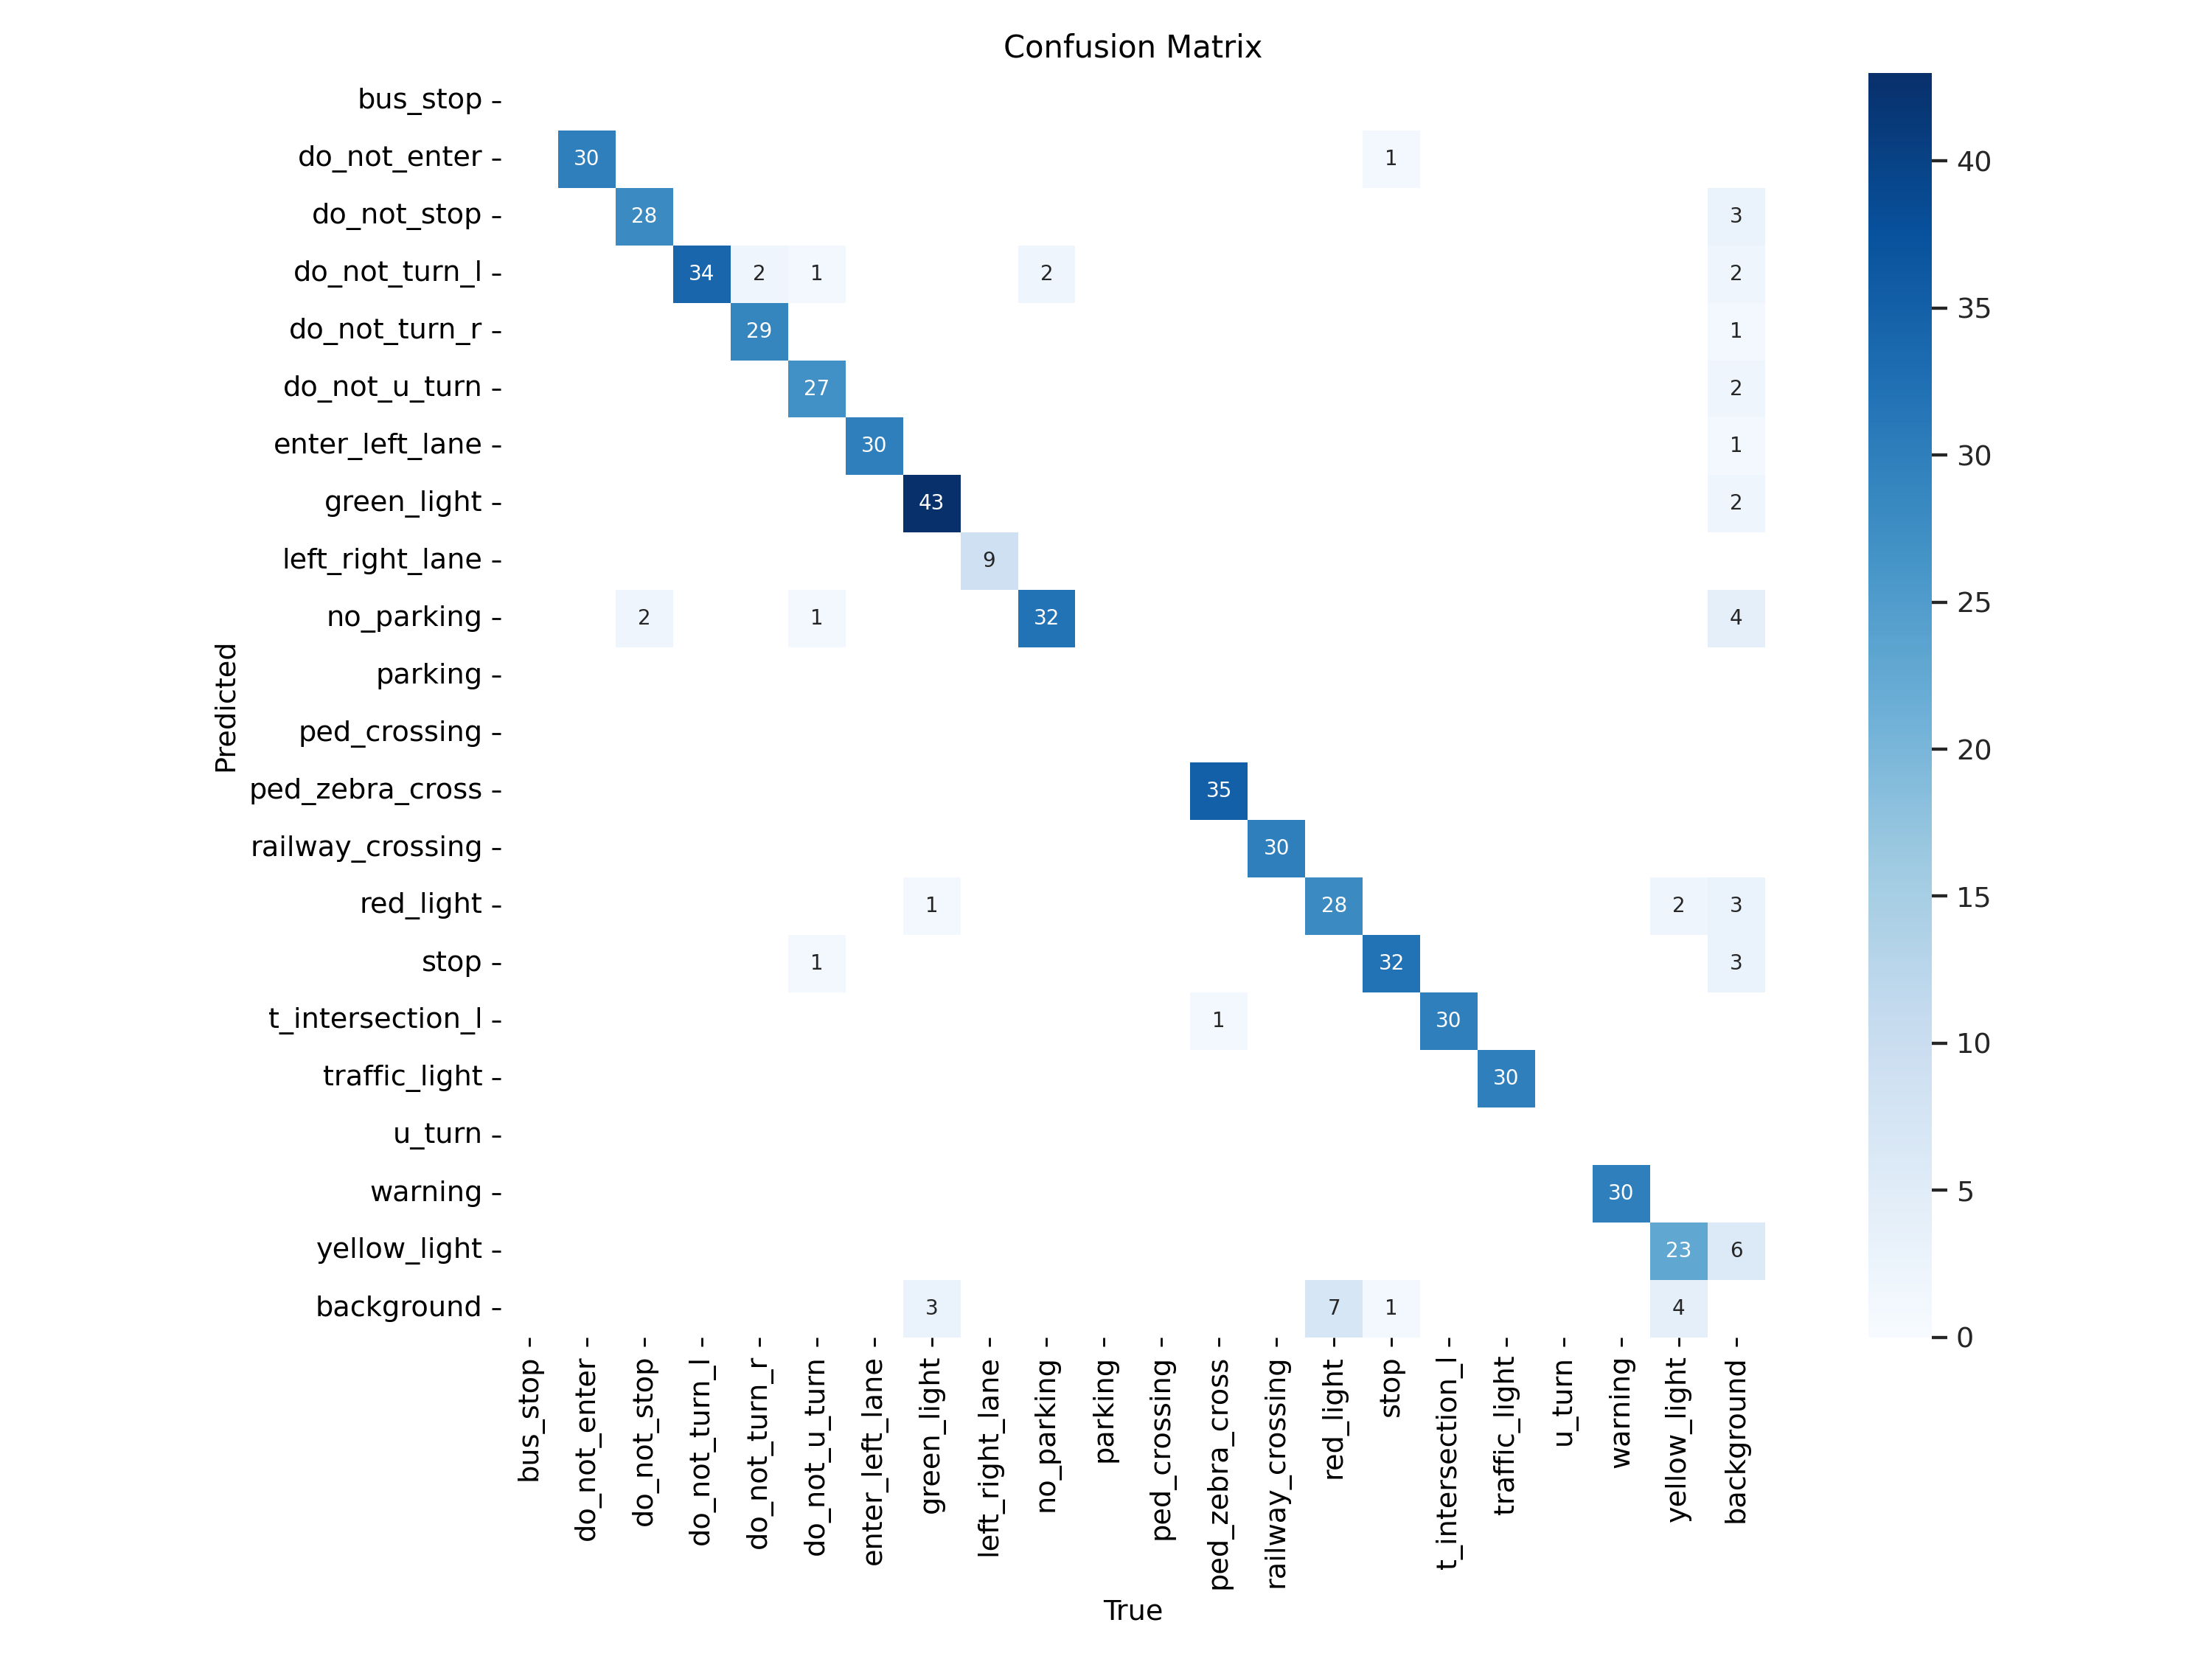

In [14]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

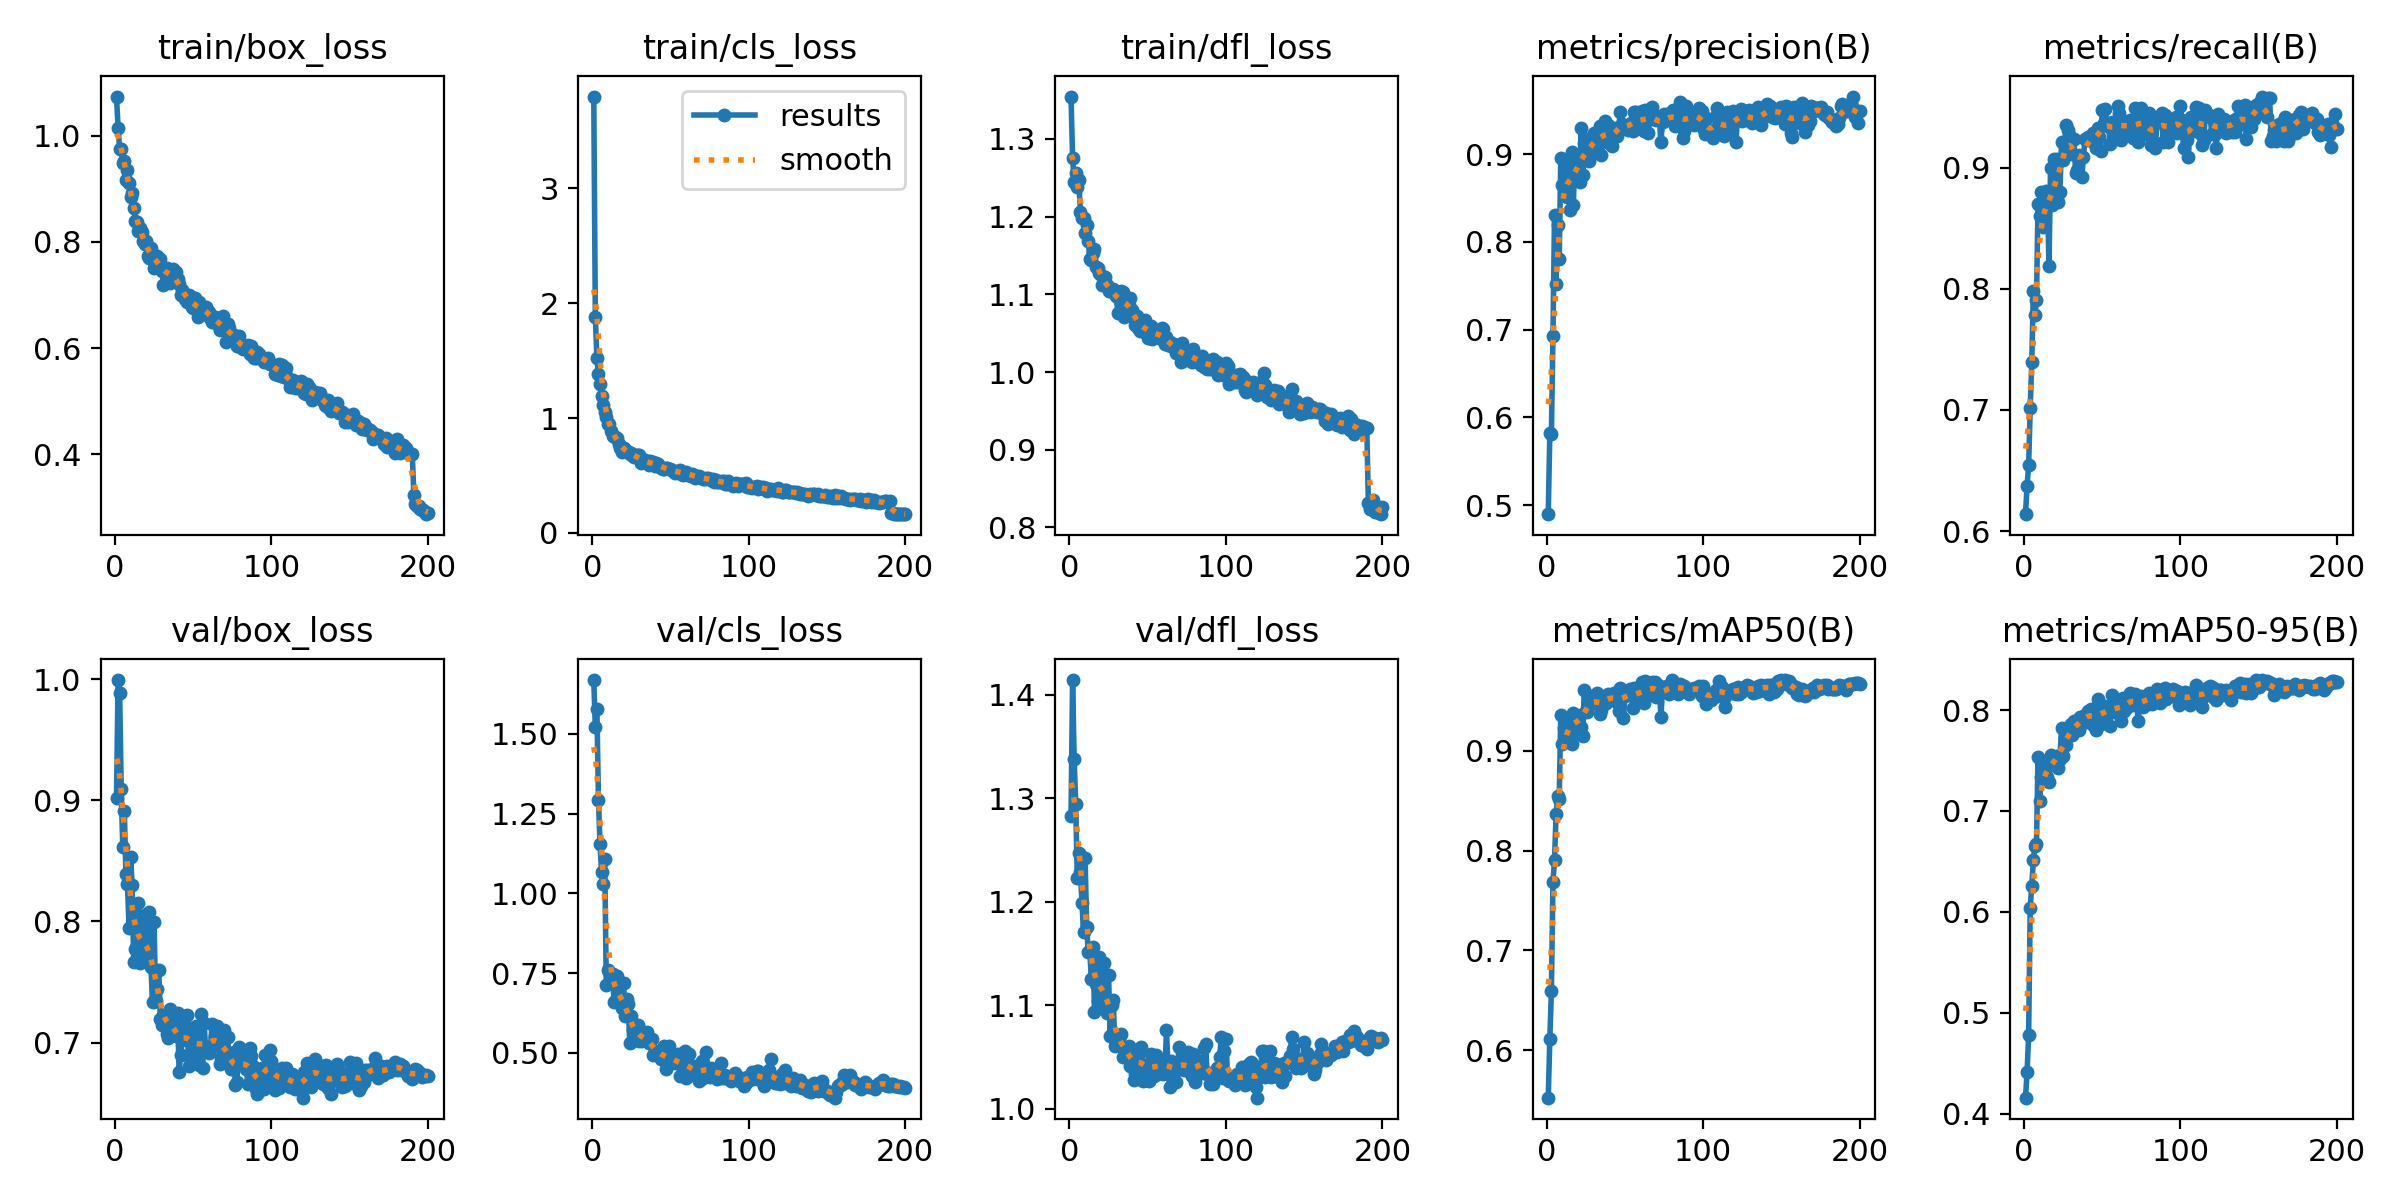

In [15]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [16]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['bus_stop',
 'do_not_enter',
 'do_not_stop',
 'do_not_turn_l',
 'do_not_turn_r',
 'do_not_u_turn',
 'enter_left_lane',
 'green_light',
 'left_right_lane',
 'no_parking',
 'parking',
 'ped_crossing',
 'ped_zebra_cross',
 'railway_crossing',
 'red_light',
 'stop',
 't_intersection_l',
 'traffic_light',
 'u_turn',
 'warning',
 'yellow_light']

In [17]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [18]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.7825959574412005
mAP 50 0.919368764160889
mAP 75 0.9080120011765299


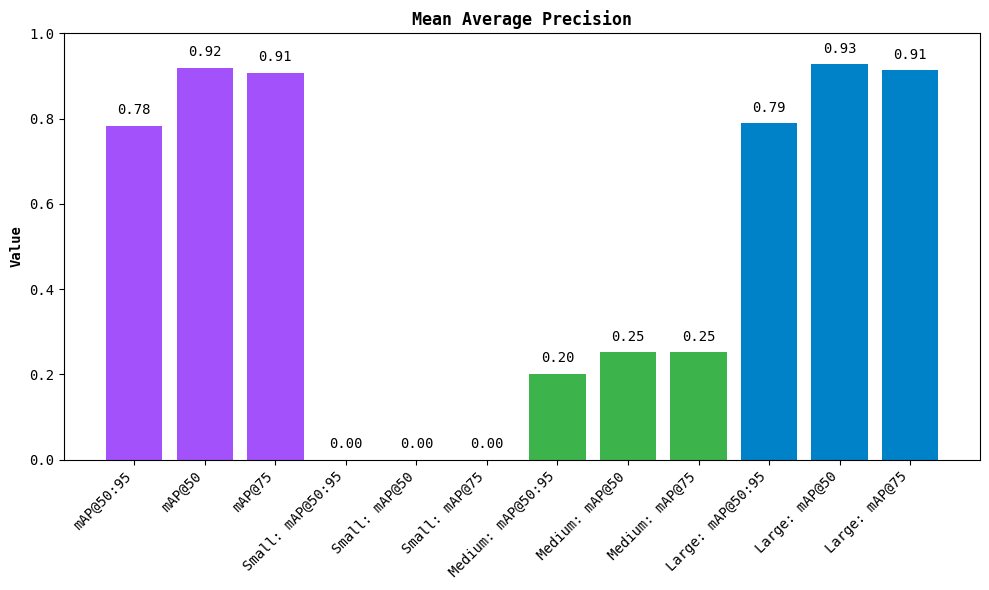

In [19]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [20]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

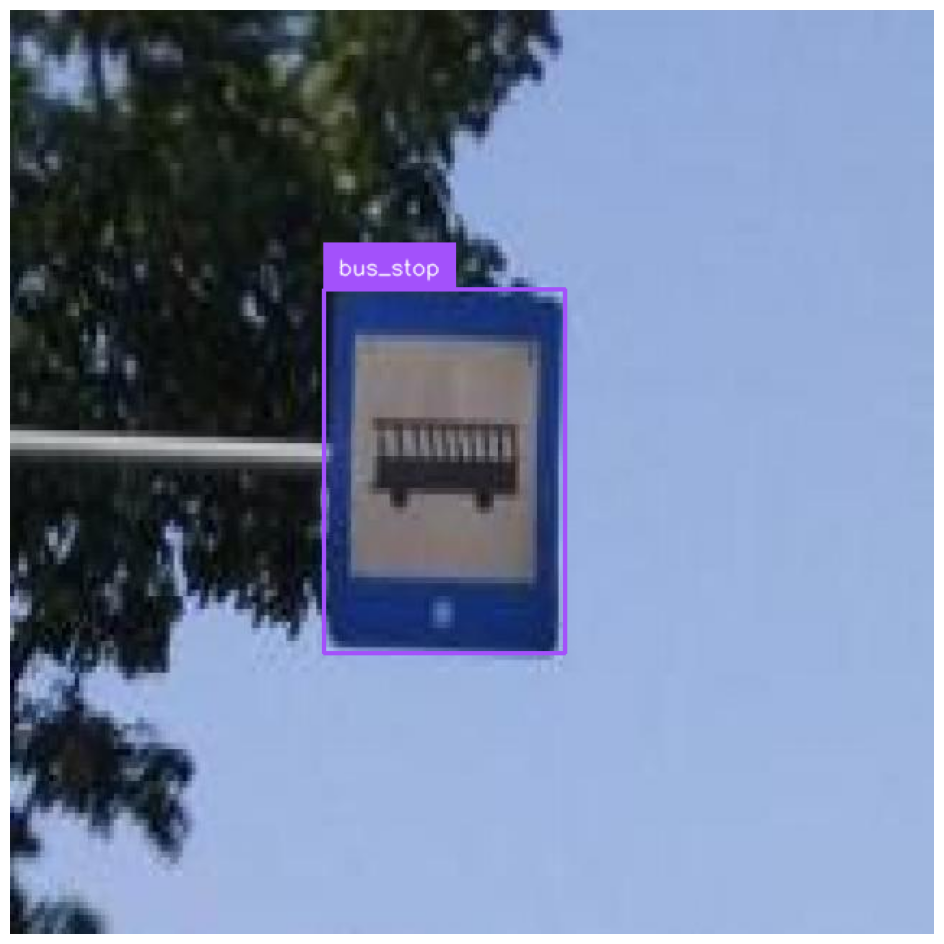

In [21]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

Saving IMG_0487_JPG.rf.dfba9cffd0691279bc1c7e3fe27a300f.jpg to IMG_0487_JPG.rf.dfba9cffd0691279bc1c7e3fe27a300f.jpg


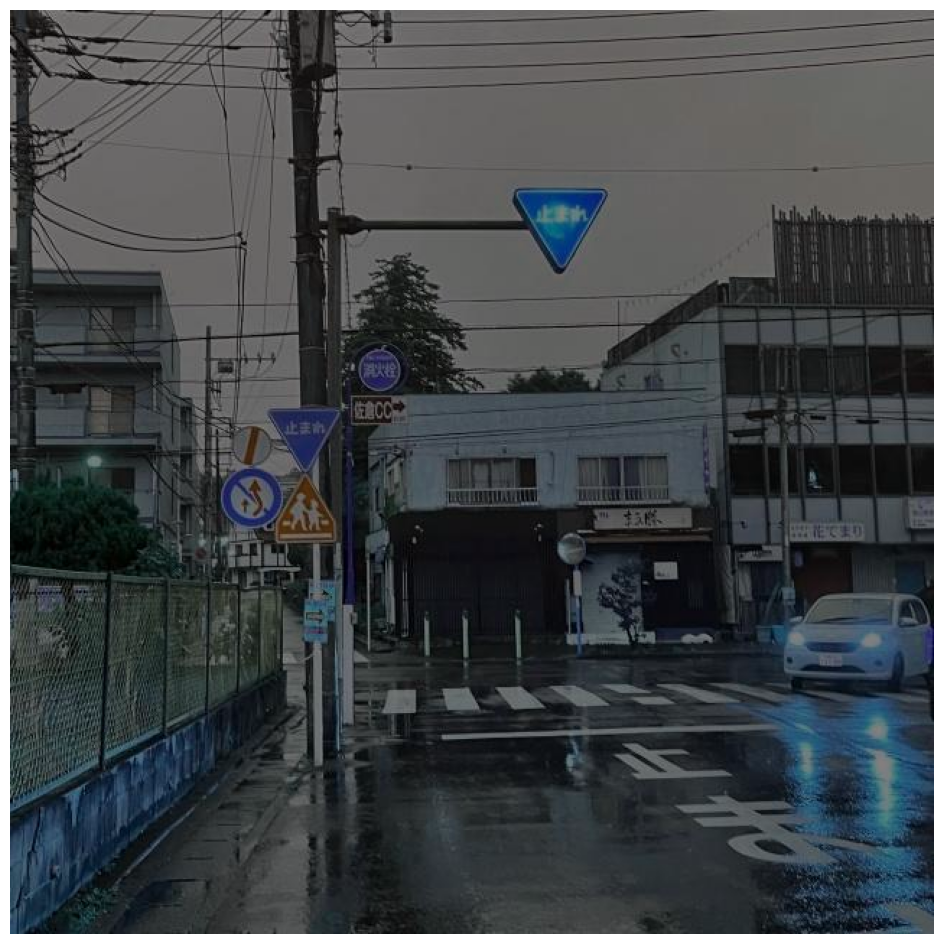

In [ ]:
import random
from google.colab import files
from PIL import Image
import cv2
import supervision as sv
from ultralytics import YOLO

# 讓使用者上傳圖片
uploaded = files.upload()

# 取得圖片路徑（假設只上傳一張）
image_path = list(uploaded.keys())[0]

# 載入模型（這裡假設你已經載入好 YOLO 模型）
model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')  # 或你訓練好的模型路徑

# 使用模型做預測
results = model(image_path, verbose=False)[0]

# 取得偵測結果並做 NMS
detections = sv.Detections.from_ultralytics(results).with_nms()

# 使用 OpenCV 讀圖（因為 sv 需要 numpy 陣列）
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 畫上 bounding box 和 label
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

# 顯示結果
sv.plot_image(annotated_image)

In [ ]:
import shutil
from google.colab import files

# 將 /content/runs 壓縮成 runs.zip
shutil.make_archive('/content/runs', 'zip', '/content/runs')

# 下載 runs.zip
files.download('/content/runs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import shutil
import os

# 確認資料夾存在後再刪除
runs_path = '/content/runs'
if os.path.exists(runs_path):
    shutil.rmtree(runs_path)
    print(f"{runs_path} 已成功刪除。")
else:
    print(f"{runs_path} 不存在，無需刪除。")


/content/runs 不存在，無需刪除。


In [ ]:
from roboflow import download_dataset
dataset = download_dataset('https://universe.roboflow.com/yokoy-vsmht/traffic-sign-ver2.0/dataset/2', 'yolov8')

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to traffic-sign-ver2.0-2 in yolov8:: 100%|██████████| 9636/9636 [00:01<00:00, 5406.40it/s]
